<h1>Simple Stock Price Regression with a Deep Neural Network</h1>
<p>This uses a DNN technique to predict stock prices for stocks on the S&P500 using only the stock price. The result is stock price predictions that are of roughly the correct magnitude, with an error of 5-12%. This is, however, inferior to the most naive prediction in which the last stock price in training data is used as the prediction for future values, even out to 120 days of trading.</p>

In [ ]:
# Import all the dependencies
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import train_test_split


<h2>Loading and Cleaning the Data</h2>

In [ ]:
# To allow spot-checking the whole dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# load the data files

# Including the stock ticker there are 123 items in the training dataset part
# of the merged file, and the -1 at the end eliminates a trailing comma
dataset = pd.read_csv('mergedSP500.csv')
trainData = dataset.iloc[:, 123:-1].copy().to_numpy()

# The target data is equally large so I can check the accuracy at the model
# at various points out in time, one day after a month, etc.
targetData = dataset.iloc[:, 1:122].copy().to_numpy()
targetData = targetData.astype(float)

# check dimensions
print("Training data shape:", trainData.shape)
print("Target shape:", targetData.shape)

Training data shape: (428, 125)
Target shape: (428, 121)


In [ ]:
# double checking the data types are right
print(type(targetData[0][0]))
print(targetData[0][0])
print(trainData[0][0])

<class 'numpy.float64'>
101.21
89.47


In [ ]:
# check for NaNs in the data
nan_rows = dataset[dataset.isnull().any(axis=1)].index
print("Rows with NaN in trainDF:", nan_rows)

Rows with NaN in trainDF: RangeIndex(start=0, stop=428, step=1)


In [ ]:
# split into training and test data
# split into test and training data
train_data, test_data, train_targets_all, test_targets_all = train_test_split(
    trainData, targetData, test_size=0.2, random_state=42)

# check dimensions
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)
print("Training target shape:", train_targets_all.shape)
print("Testing target shape:", test_targets_all.shape)

Training data shape: (342, 125)
Testing data shape: (86, 125)
Training target shape: (342, 121)
Testing target shape: (86, 121)


In [ ]:
# data normalization, making copies to have the raw stock prices available for
# comparison purposes
unNormedTrainData = train_data.copy()
unNormedTestData = test_data.copy()

mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std
test_data -= mean
test_data /= std

In [ ]:
print(type(train_data))
print(type(train_targets_all))
print(type(train_data[0][0]))
print(type(train_targets_all[0][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>


<h2> Functions for Obtaining and Displaying Results</h2>
<p> These functions make it much tidier to test a number of different models with a variety of epochs and target dates</p>
<list>
<li>showModelResults(predictions[], targets[]): displays a comparison of predictions and targets</li>
<li>noPlotResults(predictions[], targets[]): gets same results as showModelResults but doesn't create plots, used for running a sequence of tests and collecting numerical values</li>
<li>testValidationCurve(model_func, num_epochs): test and validation for specified model and epochs </li>
<li>displayValidationCurve(all_mae_histories, num_epochs): displays the results of testValidationCurve</li>
</list>

In [ ]:
# displays the error in terms of percentage of the target in absolute value
def showModelResults(predictions, targets):
  # make the comparison tuple
  comparison = [(predictions[i], targets[i]) for i in range(len(test_data))]

  # plot them against each other
  plt.figure(figsize=(10, 6))
  plt.plot([item[0] for item in comparison], label='Predictions', marker='o', linestyle='')
  plt.plot([item[1] for item in comparison], label='Actual Values', marker='x', linestyle='')
  plt.xlabel("Index of Test Sample")
  plt.ylabel("Value")
  plt.title("Predictions vs. Actual Values for Test Data")
  plt.legend()
  plt.grid(True)
  plt.show()

  # then check the percentage accuracy
  # now get the percentage each is off
  percentError = [abs(predictions[i]-targets[i])/targets[i] for i in range(len(predictions))]
  print("Mean percentage error: ", np.mean(percentError))
  print("Highest percentage error: ", max(percentError))
  print("Lowest percentage error: ", min(percentError))
  print("Median percentage error: ", np.median(percentError))
  print("Standard deviation of percentage error: ", np.std(percentError))

  return np.mean(percentError)



In [ ]:
# same as ShowModelResults() but with no display
def noPlotResults(predictions, targets):
  # make the comparison tuple
  comparison = [(predictions[i], targets[i]) for i in range(len(test_data))]
  percentError = [abs(predictions[i]-targets[i])/targets[i] for i in range(len(predictions))]
  result = (np.mean(percentError),max(percentError),min(percentError),np.median(percentError),np.std(percentError))

  #print("Mean percentage error: ", np.mean(percentError))
  #print("Highest percentage error: ", max(percentError))
  #print("Lowest percentage error: ", min(percentError))
  #print("Median percentage error: ", np.median(percentError))
  #print("Standard deviation of percentage error: ", np.std(percentError))

  return result  # return the mean percentage error

In [ ]:
# runs the validation testing and returns all mean-average-error histories
def testValidationCurve(model_func, num_epochs = 500, targetDaysOut = 1):
  # start by predicting the stock price the next trading day
  if targetDaysOut >= len(train_targets_all):
    print("Target days out is too large")
    return

  # select the target date to aim for
  train_targets = train_targets_all[:,-1*targetDaysOut]
  test_targets = test_targets_all[:,-1*targetDaysOut]

  #### saving validation logs at each fold
  k = 4
  num_val_samples = len(train_data) // k
  num_epochs = 500
  all_scores = []
  all_mae_histories = []   #added

  for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) *  num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1) *  num_val_samples:]],
        axis=0)
    model = build_model1()
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs = num_epochs, batch_size=16, verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

  return(all_mae_histories)


In [ ]:
# displays the results of testValidationCurve()
def displayValidationCurve(all_mae_histories, num_epochs):
  average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
  print(average_mae_history)
  average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
  print(average_mae_history)
  plt.plot(range(1,len(average_mae_history) + 1), average_mae_history)
  plt.xlabel("Epochs")
  plt.ylabel("Validation MAE")
  plt.show()

<h2>Evaluation Metric: Last Price as Prediction</h2>
<p>Since the stock price at some time in the future depends on the previous price, the divergence between those is a reasonable metric to try to exceed. To be meaningfully accurate, the DNN ought to be superior to a prediction that the price will remain the same.</p>

In [ ]:
# get the last price during the data interval and use it as a prediction
predictions = unNormedTestData[:,0]

defaultMPE = []

# iterate over all the possible targets (stock prices at dates in future) and compare with prediction
for i in range(len(test_targets_all[0])):
  currentTarget = test_targets_all[:,-1 - i]
  res = noPlotResults(predictions, currentTarget)
  defaultMPE.append(res)

print(defaultMPE)


[(np.float64(0.0159406803222652), np.float64(0.08866442199775543), np.float64(0.0), np.float64(0.013315248851508426), np.float64(0.014002007114324871)), (np.float64(0.025714762809557482), np.float64(0.13534475757329645), np.float64(0.0004390297442652426), np.float64(0.020430645106652063), np.float64(0.022053791463276132)), (np.float64(0.02366097583194058), np.float64(0.13057015770319436), np.float64(0.0), np.float64(0.018215215505651524), np.float64(0.021055183760886366)), (np.float64(0.025645980739007687), np.float64(0.12733357525906208), np.float64(0.0008448324415657882), np.float64(0.019614213286560676), np.float64(0.02248503332324139)), (np.float64(0.025998119172354138), np.float64(0.12026664197759461), np.float64(0.0008434073657576929), np.float64(0.021547748717316545), np.float64(0.02284992153027125)), (np.float64(0.027306800403582833), np.float64(0.1294688695976851), np.float64(0.00031563165785529484), np.float64(0.021777632594350282), np.float64(0.023952594217625637)), (np.floa

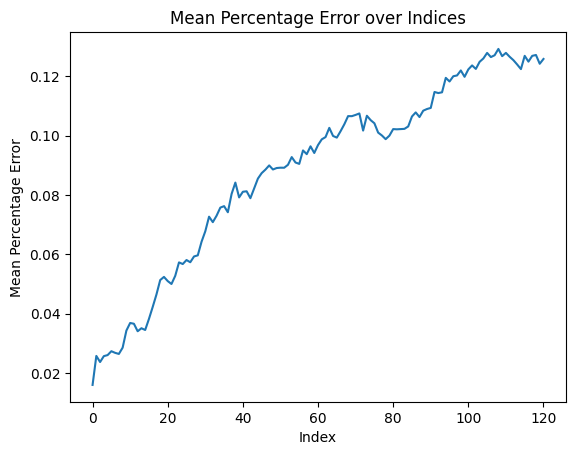

In [ ]:
# Extract the first value (mean percentage error) from each tuple in defaultMPE
mean_percentage_errors = [item[0] for item in defaultMPE]

# Create a list of indices
indices = list(range(len(defaultMPE)))

# Plot the data
plt.plot(indices, mean_percentage_errors)
plt.xlabel("Index")
plt.ylabel("Mean Percentage Error")
plt.title("Mean Percentage Error over Indices")
plt.show()

<p>This result is what one would expect, the error being quite small with there usually being a small variation in stock price from one day to the next, growing over time. This naive prediction will therefore be the baseline to compare the CNN's results with.</p>

<h2>Building the Model</h2>
<p>Below is the code for the regression model CNN, starting with a simplest model with one fully-connected hidden layer</p>

In [ ]:
# model definition for the simple model with 1 fully connected hidden layer
def build_model1():
  model = keras.Sequential([
      layers.Input(shape=(125,)),
      layers.Dense(125,activation = 'relu'),
      layers.Dense(125,activation = 'relu'),
      layers.Dense(1)
  ])
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(132.79830741882324), np.float64(115.42337989807129), np.float64(98.11142158508301), np.float64(87.78635215759277), np.float64(79.49787330627441), np.float64(74.6254825592041), np.float64(74.3301649093628), np.float64(75.79973316192627), np.float64(74.08202934265137), np.float64(71.27541255950928), np.float64(74.33992576599121), np.float64(73.21603488922119), np.float64(74.0467700958252), np.float64(70.82617568969727), np.float64(72.80018424987793), np.float64(71.37845134735107), np.float64(70.03922843933105), np.float64(69.09666633605957), np.float64(66.70383262634277), np.float64(67.24211597442627), np.float64(65.89003276824951), np.float64(66.44064521789551), np.float64(62.037954330444336), np.float64(62.0833158493042), np.float64(61.6873140335083), np.float64(57.97616195678711), np.float64(55.39329814910889), np.float64(56.63669013977051), np.float64(54.20447826385498), np.float64(50.403258323669

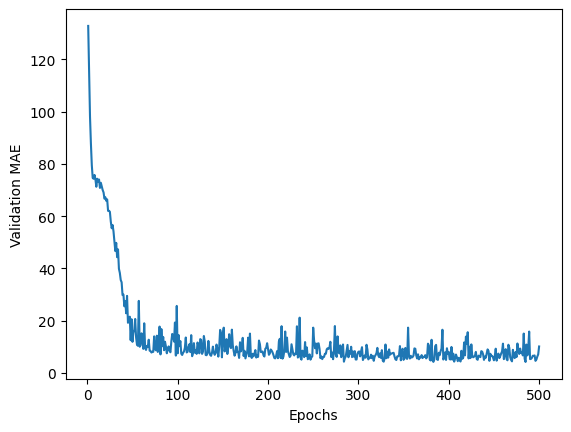

In [ ]:
results = testValidationCurve(build_model1,500,1)
displayValidationCurve(results,500)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 95.8160 - mae: 5.8791  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


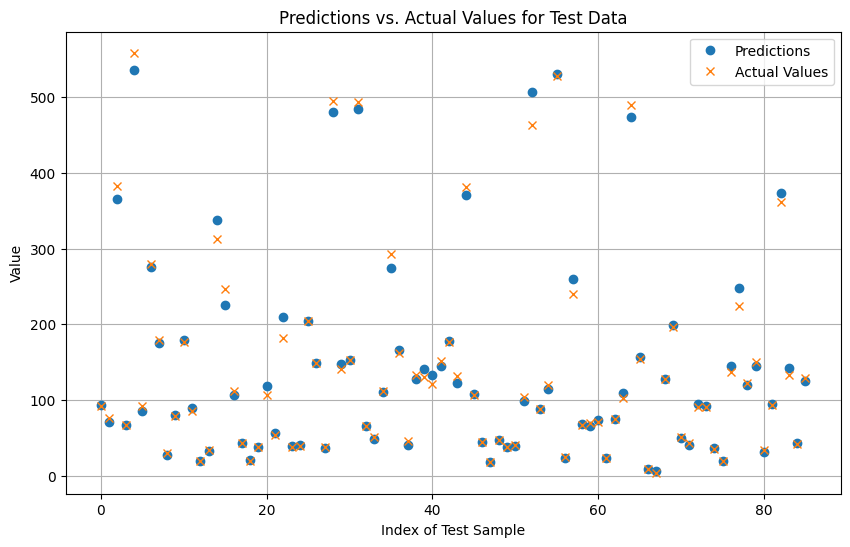

Mean percentage error:  0.043583210710705506
Highest percentage error:  [0.49487919]
Lowest percentage error:  [0.00057114]
Median percentage error:  0.030157958720094476
Standard deviation of percentage error:  0.05803036302658914


np.float64(0.043583210710705506)

In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-1]
test_targets = test_targets_all[:,-1]
model.fit(train_data, train_targets, epochs = 100, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

<h2>Larger batches don't help</h2>

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 126.8752 - mae: 7.2330 


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


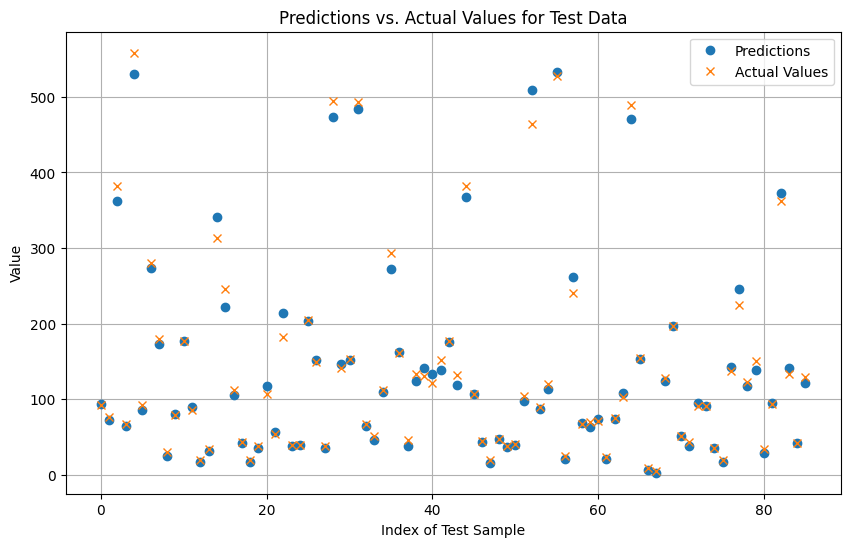

Mean percentage error:  0.0651827652862283
Highest percentage error:  [0.40620108]
Lowest percentage error:  [0.00081253]
Median percentage error:  0.047083179560508226
Standard deviation of percentage error:  0.06752487504543263


np.float64(0.0651827652862283)

In [ ]:
modelMore = build_model1()
train_targets = train_targets_all[:,-1]
test_targets = test_targets_all[:,-1]
modelMore.fit(train_data, train_targets, epochs = 100, batch_size = 32, verbose = 0)
test_mse_score, test_mae_score = modelMore.evaluate(test_data, test_targets)
showModelResults(modelMore.predict(test_data), test_targets)

<p>This establishes that the model is mechanically sounds, but since the next day closing price is likely to be quite similar to the last day of training data, this does not establish significant predictive power. Next step is to test the same model architecture for closing price a week out, 5 trading days.</p>

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(15.48960256576538), np.float64(21.763129711151123), np.float64(31.742613554000854), np.float64(13.51418924331665), np.float64(11.450051426887512), np.float64(34.148622274398804), np.float64(44.91443610191345), np.float64(10.4250648021698), np.float64(39.35405468940735), np.float64(16.223390340805054), np.float64(10.962573528289795), np.float64(30.62214159965515), np.float64(23.92860698699951), np.float64(28.21078896522522), np.float64(24.9027841091156), np.float64(21.346304655075073), np.float64(11.742364764213562), np.float64(14.08078646659851), np.float64(14.280842781066895), np.float64(12.08282721042633), np.float64(35.0452184677124), np.float64(11.58820354938507), np.float64(9.521779775619507), np.float64(19.654717564582825), np.float64(28.233986854553223), np.float64(11.756537914276123), np.float64(16.38629651069641), np.float64(9.411174058914185), np.float64(19.10707449913025), np.float64(11.6

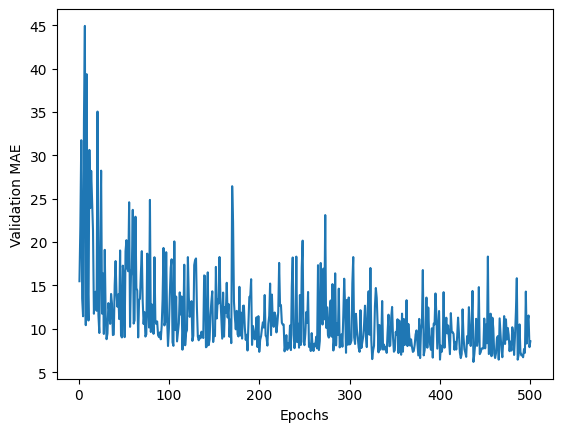

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 200.7536 - mae: 9.3559 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


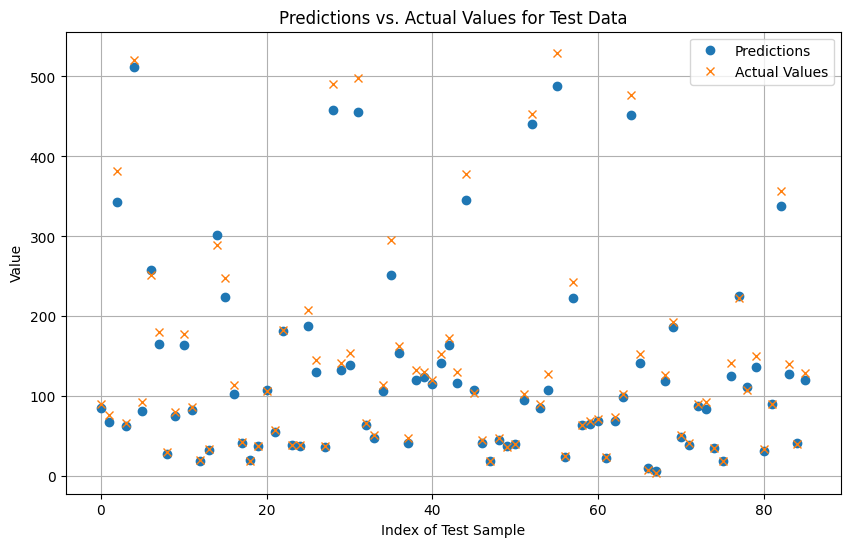

Mean percentage error:  0.06390415050163106
Highest percentage error:  [0.37135587]
Lowest percentage error:  [0.00348336]
Median percentage error:  0.058423067027881956
Standard deviation of percentage error:  0.04808033620384883


In [ ]:
results = testValidationCurve(build_model1,500,5)
displayValidationCurve(results,500)
model = build_model1()
train_targets = train_targets_all[:,-5]
test_targets = test_targets_all[:,-5]
model.fit(train_data, train_targets, epochs = 500, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

Then 15 trading days, 2 weeks.

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(39.0680730342865), np.float64(32.24127519130707), np.float64(28.252805471420288), np.float64(9.559205651283264), np.float64(10.969374537467957), np.float64(40.51221942901611), np.float64(20.291501998901367), np.float64(36.04720640182495), np.float64(9.704575300216675), np.float64(13.023146867752075), np.float64(19.7731032371521), np.float64(27.613061785697937), np.float64(8.906845808029175), np.float64(12.451601266860962), np.float64(9.245176315307617), np.float64(11.807667255401611), np.float64(16.51082968711853), np.float64(12.006255984306335), np.float64(6.788044571876526), np.float64(15.401870727539062), np.float64(18.594214916229248), np.float64(8.65276837348938), np.float64(12.480528593063354), np.float64(6.926828980445862), np.float64(7.565683007240295), np.float64(6.661486625671387), np.float64(16.93755841255188), np.float64(10.327837109565735), np.float64(11.538756847381592), np.float64(21.

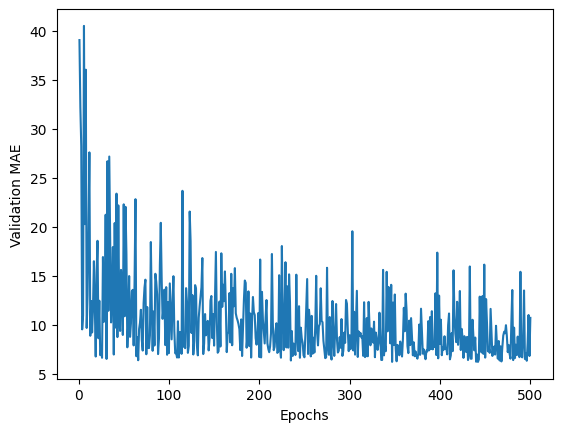

In [ ]:
results = testValidationCurve(build_model1,500,10)
displayValidationCurve(results,500)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 428.3654 - mae: 13.2062 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


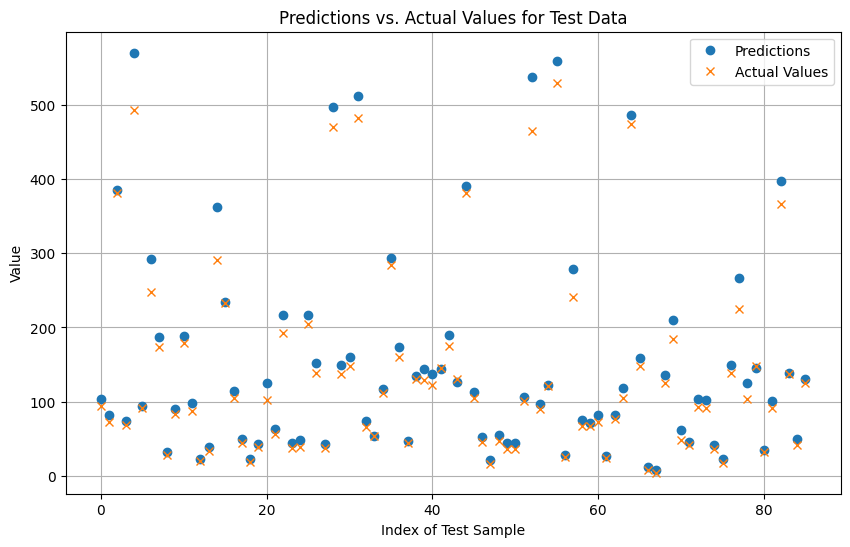

Mean percentage error:  0.12153474361317829
Highest percentage error:  [0.88863198]
Lowest percentage error:  [0.00218615]
Median percentage error:  0.1018173964278904
Standard deviation of percentage error:  0.11245147743931444


In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-10]
test_targets = test_targets_all[:,-10]
model.fit(train_data, train_targets, epochs = 500, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

<h4>Now 15 days</h4>

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(20.113795042037964), np.float64(11.866058588027954), np.float64(9.26279902458191), np.float64(18.137019395828247), np.float64(26.940751552581787), np.float64(12.316473722457886), np.float64(28.696125745773315), np.float64(18.192527532577515), np.float64(16.158947229385376), np.float64(30.005414485931396), np.float64(10.062986373901367), np.float64(16.467562437057495), np.float64(63.09699273109436), np.float64(11.764500617980957), np.float64(10.991652250289917), np.float64(15.477551698684692), np.float64(22.557017922401428), np.float64(22.329076528549194), np.float64(11.10070788860321), np.float64(39.55718016624451), np.float64(9.757771253585815), np.float64(26.787405252456665), np.float64(36.889134645462036), np.float64(9.177801489830017), np.float64(20.11303174495697), np.float64(36.97235655784607), np.float64(11.841264128684998), np.float64(10.23362123966217), np.float64(13.307868599891663), np.fl

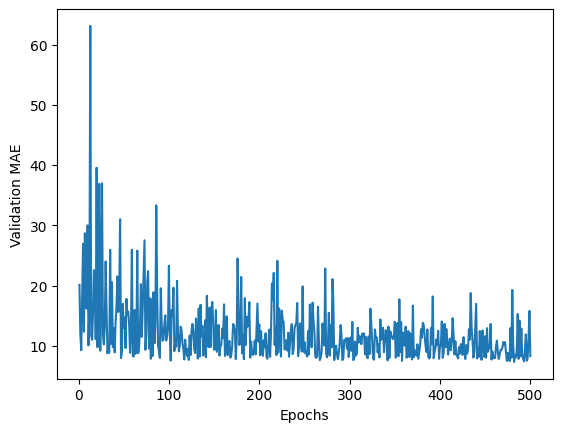

In [ ]:
results = testValidationCurve(build_model1,500,15)
displayValidationCurve(results,500)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 177.3647 - mae: 8.3217 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


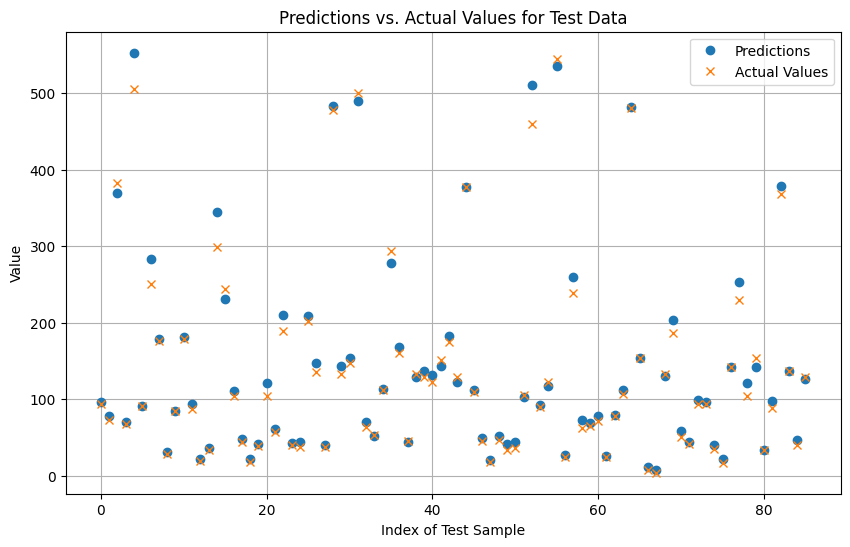

Mean percentage error:  0.08249563097964752
Highest percentage error:  [0.77219472]
Lowest percentage error:  [0.00063574]
Median percentage error:  0.05910923661569718
Standard deviation of percentage error:  0.09894671837755709


In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-15]
test_targets = test_targets_all[:,-15]
model.fit(train_data, train_targets, epochs = 500, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 160.8079 - mae: 8.3309 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


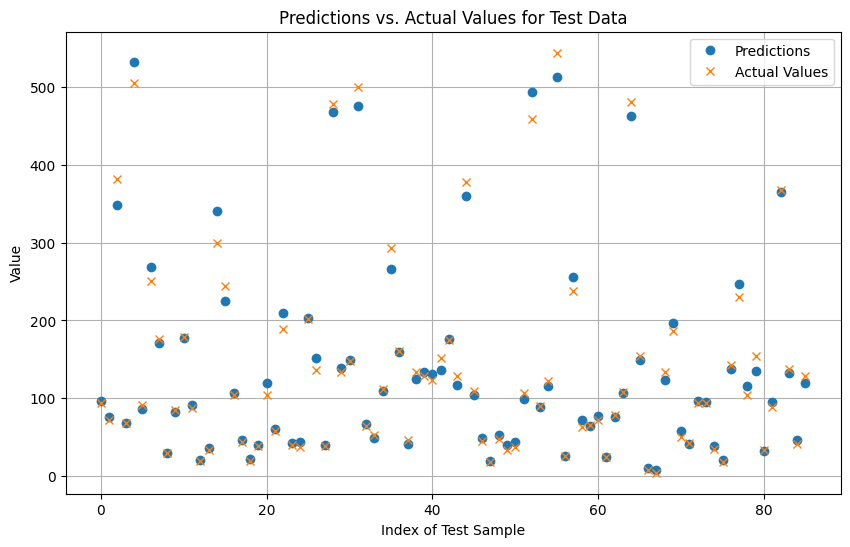

Mean percentage error:  0.0737897019670975
Highest percentage error:  [0.69817133]
Lowest percentage error:  [0.00011734]
Median percentage error:  0.05442691668892594
Standard deviation of percentage error:  0.08551354564839467


In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-15]
test_targets = test_targets_all[:,-15]
model.fit(train_data, train_targets, epochs = 290, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

<h4>20 Days</h4>

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(11.61800742149353), np.float64(27.749011278152466), np.float64(33.596845865249634), np.float64(19.854776620864868), np.float64(29.519402027130127), np.float64(24.964333534240723), np.float64(22.567690134048462), np.float64(25.697065830230713), np.float64(33.54261755943298), np.float64(26.238057613372803), np.float64(21.92245841026306), np.float64(10.513312339782715), np.float64(9.389020562171936), np.float64(15.288065671920776), np.float64(23.593341588974), np.float64(13.164841175079346), np.float64(50.68602418899536), np.float64(14.792547225952148), np.float64(15.951131820678711), np.float64(21.06306028366089), np.float64(13.51441502571106), np.float64(9.451107859611511), np.float64(19.36659288406372), np.float64(18.250109791755676), np.float64(26.323755383491516), np.float64(9.414063215255737), np.float64(21.24839162826538), np.float64(27.88816499710083), np.float64(18.66166841983795), np.float64(

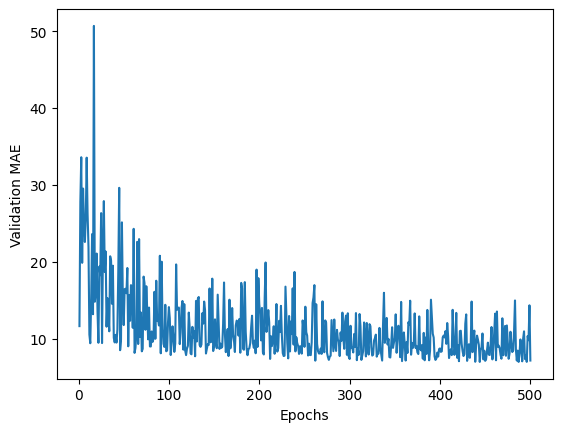

In [ ]:
results = testValidationCurve(build_model1,500,20)
displayValidationCurve(results,500)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 328.3719 - mae: 8.3915 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


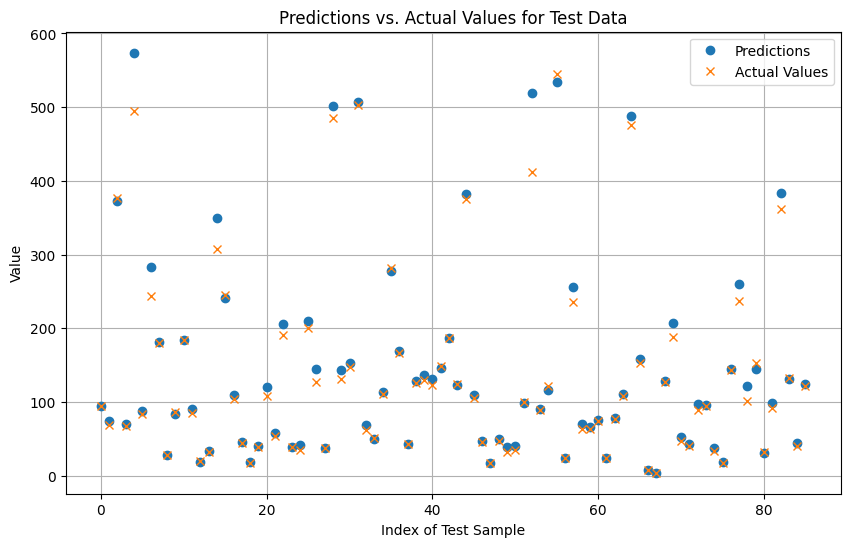

Mean percentage error:  0.05513346915237138
Highest percentage error:  [0.26048353]
Lowest percentage error:  [0.00059211]
Median percentage error:  0.03579443390393698
Standard deviation of percentage error:  0.05339613512335975


In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-20]
test_targets = test_targets_all[:,-20]
model.fit(train_data, train_targets, epochs = 400, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

<h4>25 Days, Roughly a Month or More</h4>

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(57.047462940216064), np.float64(31.383151054382324), np.float64(34.51808285713196), np.float64(18.836267232894897), np.float64(43.58191919326782), np.float64(12.884436845779419), np.float64(11.869391202926636), np.float64(34.66007614135742), np.float64(13.985294103622437), np.float64(19.030123233795166), np.float64(22.09385919570923), np.float64(43.62442135810852), np.float64(12.27524733543396), np.float64(20.933369159698486), np.float64(16.250873804092407), np.float64(27.802907466888428), np.float64(16.557807207107544), np.float64(13.001576900482178), np.float64(20.621487617492676), np.float64(32.076505184173584), np.float64(32.219709157943726), np.float64(17.763849020004272), np.float64(12.926494240760803), np.float64(13.786287546157837), np.float64(10.865689754486084), np.float64(11.37869906425476), np.float64(28.791606187820435), np.float64(13.66464376449585), np.float64(20.71567726135254), np.f

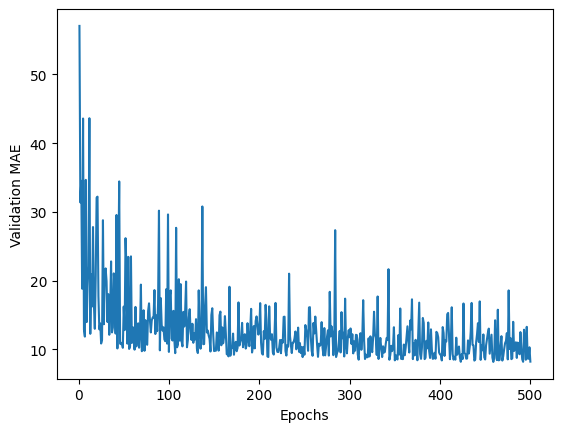

In [ ]:
results = testValidationCurve(build_model1,500,25)
displayValidationCurve(results,500)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 422.6353 - mae: 8.7286
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


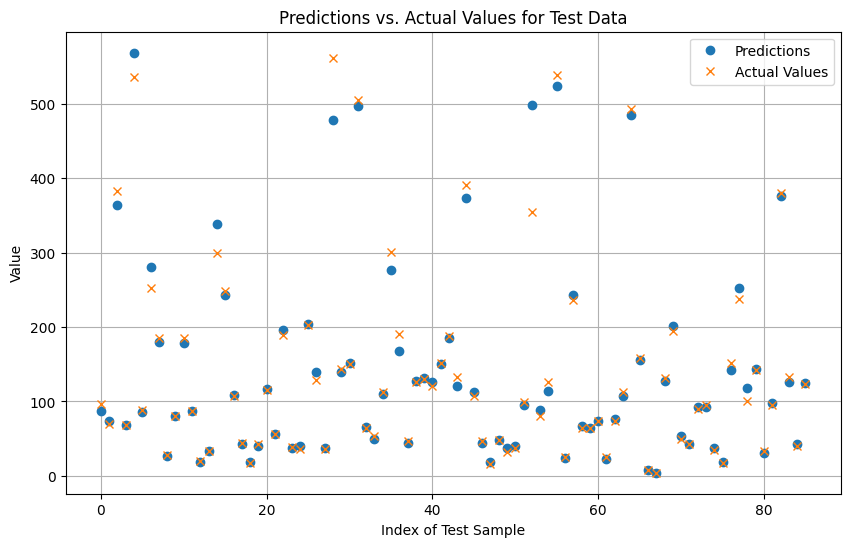

Mean percentage error:  0.05276450174969322
Highest percentage error:  [0.4022443]
Lowest percentage error:  [9.2641519e-05]
Median percentage error:  0.038386590612934604
Standard deviation of percentage error:  0.054247854590259936


In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-25]
test_targets = test_targets_all[:,-25]
model.fit(train_data, train_targets, epochs = 500, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

<h4>While the validation curves are slightly messier as time goes on, just eyeballing the best fit it is possible to keep the error relatively small on the scale of 1 month. This accords well with the idea that stock prices on a short term are not going to change a tremendous amount. By way of contrast I then tested 120 days out to see if this makes an obvious difference.</h4>

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(59.781009674072266), np.float64(31.198283195495605), np.float64(46.556503772735596), np.float64(55.62630605697632), np.float64(33.073232650756836), np.float64(48.413902282714844), np.float64(32.72056722640991), np.float64(23.17815589904785), np.float64(38.82502031326294), np.float64(44.58094835281372), np.float64(30.67582416534424), np.float64(23.752872943878174), np.float64(22.382850646972656), np.float64(34.680821895599365), np.float64(23.507637977600098), np.float64(30.431188583374023), np.float64(25.195903301239014), np.float64(24.68781328201294), np.float64(26.23069715499878), np.float64(23.79476833343506), np.float64(49.2660436630249), np.float64(35.12558317184448), np.float64(26.978094577789307), np.float64(23.51338243484497), np.float64(27.13106346130371), np.float64(31.289505004882812), np.float64(27.465683460235596), np.float64(27.685999393463135), np.float64(27.320541858673096), np.float6

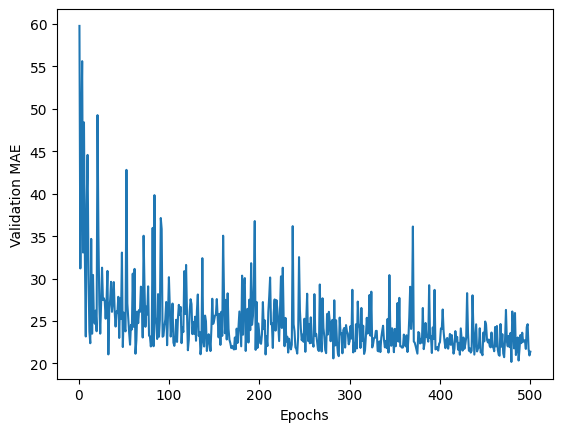

In [ ]:
results = testValidationCurve(build_model1,500,120)
displayValidationCurve(results,500)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1201.4230 - mae: 17.9907 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


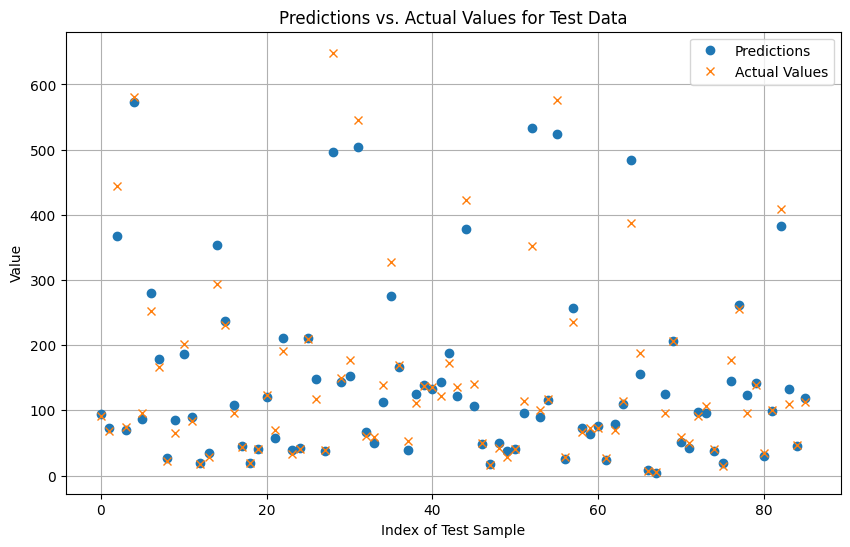

Mean percentage error:  0.12030392573152014
Highest percentage error:  [0.51566382]
Lowest percentage error:  [0.00028]
Median percentage error:  0.10233403551929837
Standard deviation of percentage error:  0.09530735048851725


In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-120]
test_targets = test_targets_all[:,-120]
model.fit(train_data, train_targets, epochs = 500, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

<h4>With this increase in error, I then backfill a few points to generate a plotable dataset.</h4>

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(28.551111698150635), np.float64(21.94330644607544), np.float64(20.37501859664917), np.float64(23.060495376586914), np.float64(21.106997966766357), np.float64(57.12408208847046), np.float64(26.813416242599487), np.float64(23.739963054656982), np.float64(42.012916564941406), np.float64(19.861042976379395), np.float64(16.84938931465149), np.float64(23.940741062164307), np.float64(32.78729844093323), np.float64(21.60354709625244), np.float64(32.8277633190155), np.float64(34.772836208343506), np.float64(24.172559022903442), np.float64(22.100116729736328), np.float64(17.609023094177246), np.float64(18.307746648788452), np.float64(19.164212703704834), np.float64(24.843402862548828), np.float64(19.5482919216156), np.float64(17.159372568130493), np.float64(19.80120038986206), np.float64(22.250675439834595), np.float64(16.657939672470093), np.float64(33.945008754730225), np.float64(17.349440574645996), np.flo

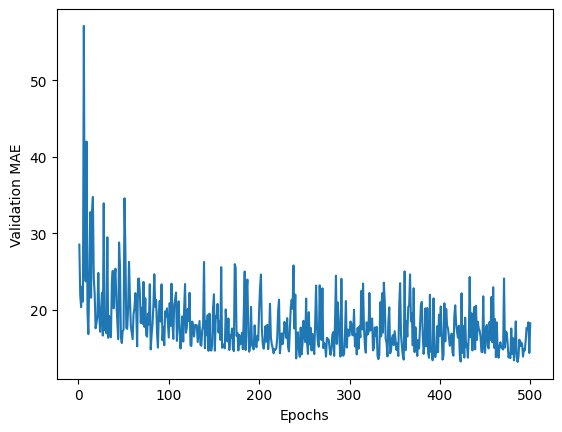

In [ ]:
results = testValidationCurve(build_model1,500,50)
displayValidationCurve(results,500)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1246.2634 - mae: 19.3343 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


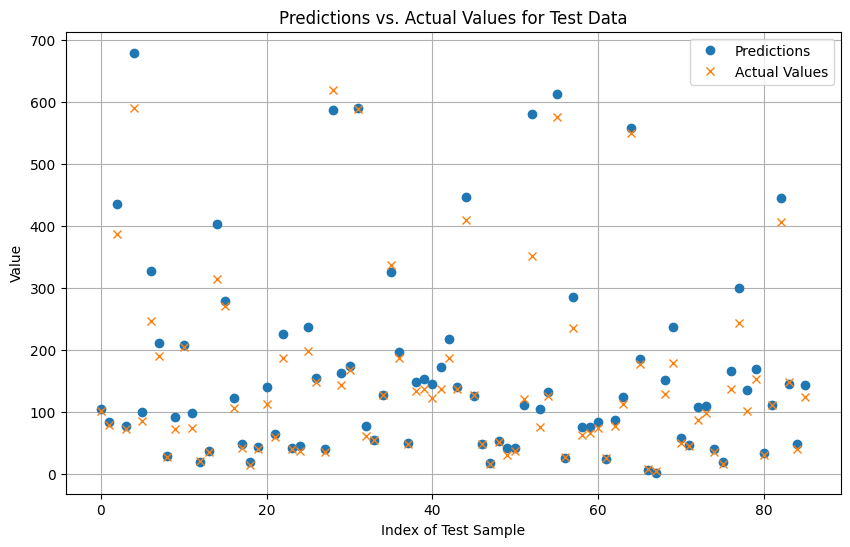

Mean percentage error:  0.13897488659262722
Highest percentage error:  [0.6524896]
Lowest percentage error:  [0.00181625]
Median percentage error:  0.11878507274562197
Standard deviation of percentage error:  0.11876454581536568


In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-50]
test_targets = test_targets_all[:,-50]
model.fit(train_data, train_targets, epochs = 500, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(23.21373462677002), np.float64(25.55467987060547), np.float64(89.76556587219238), np.float64(58.97406625747681), np.float64(43.1336874961853), np.float64(34.396953105926514), np.float64(20.722683429718018), np.float64(23.167386054992676), np.float64(45.13615274429321), np.float64(27.209606170654297), np.float64(35.66494417190552), np.float64(48.02524375915527), np.float64(25.095865726470947), np.float64(23.961166381835938), np.float64(40.480186462402344), np.float64(33.01646947860718), np.float64(35.9945170879364), np.float64(20.058119297027588), np.float64(21.72209596633911), np.float64(33.96193885803223), np.float64(19.012842655181885), np.float64(35.93696594238281), np.float64(37.0223650932312), np.float64(18.31881332397461), np.float64(40.53130006790161), np.float64(28.524725675582886), np.float64(22.791202068328857), np.float64(19.214255809783936), np.float64(26.429900407791138), np.float64(31.

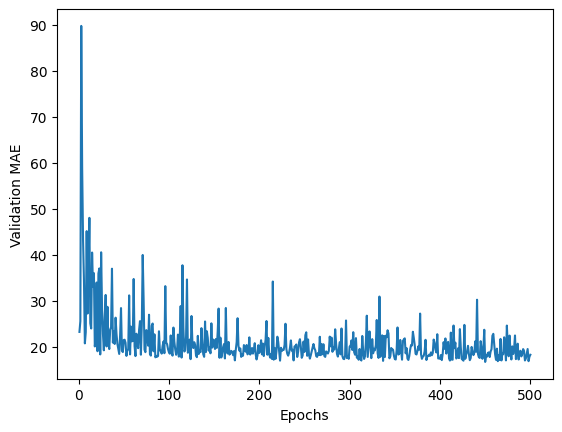

In [ ]:
results = testValidationCurve(build_model1,500,75)
displayValidationCurve(results,500)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1834.4973 - mae: 22.6036 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


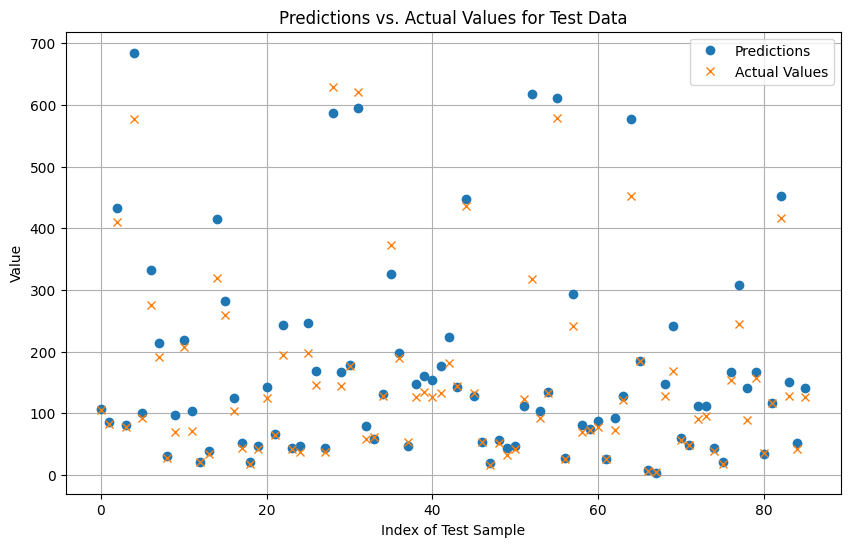

Mean percentage error:  0.1539913522331133
Highest percentage error:  [0.94971704]
Lowest percentage error:  [0.00021997]
Median percentage error:  0.12541948530718527
Standard deviation of percentage error:  0.14403738989710219


In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-75]
test_targets = test_targets_all[:,-75]
model.fit(train_data, train_targets, epochs = 500, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(38.354812145233154), np.float64(64.89322710037231), np.float64(23.09454917907715), np.float64(33.495816230773926), np.float64(35.9334659576416), np.float64(22.934853553771973), np.float64(41.05889940261841), np.float64(33.06789183616638), np.float64(39.21260595321655), np.float64(25.9863224029541), np.float64(24.0484299659729), np.float64(23.744614124298096), np.float64(27.09171152114868), np.float64(20.029775142669678), np.float64(35.025564193725586), np.float64(26.156210899353027), np.float64(23.849630117416382), np.float64(31.372073650360107), np.float64(18.49733304977417), np.float64(30.7844820022583), np.float64(21.58405828475952), np.float64(23.714600086212158), np.float64(36.0665864944458), np.float64(20.228615283966064), np.float64(21.72575545310974), np.float64(40.24498796463013), np.float64(28.32363486289978), np.float64(37.56843400001526), np.float64(21.912924766540527), np.float64(19.765

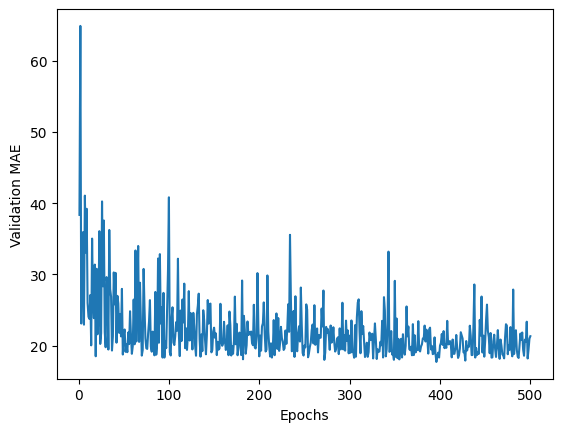

In [ ]:
results = testValidationCurve(build_model1,500,100)
displayValidationCurve(results,500)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1248.5450 - mae: 18.9156
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


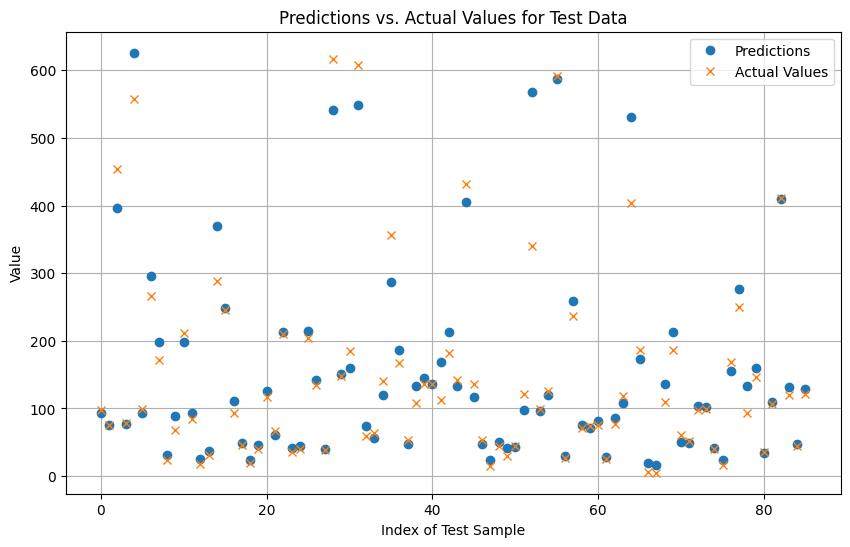

Mean percentage error:  0.1840281693488912
Highest percentage error:  [2.32324935]
Lowest percentage error:  [0.00083119]
Median percentage error:  0.10090217604332788
Standard deviation of percentage error:  0.32605787316316154


np.float64(0.1840281693488912)

In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-100]
test_targets = test_targets_all[:,-100]
model.fit(train_data, train_targets, epochs = 500, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

<h2>Comparison with Naive Prediction</h2>
<p>I manually gathered the Mean Percentage Error for these into a list and plotted it against the naive prediction, that the stock price would remain the same, showing that at a certain distance out in time they become equally bad, but that this simple model is demonstrably worse than the naive prediction.</p>

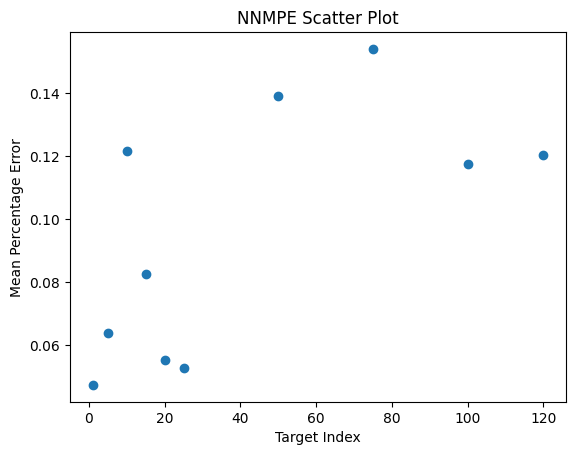

In [ ]:
import matplotlib.pyplot as plt

# Extract x and y values from NNMPE
x_values = [item[0] for item in NNMPE]
y_values = [item[1] for item in NNMPE]

# Create a scatter plot
plt.scatter(x_values, y_values)
plt.xlabel("Target Index")
plt.ylabel("Mean Percentage Error")
plt.title("NNMPE Scatter Plot")
plt.show()

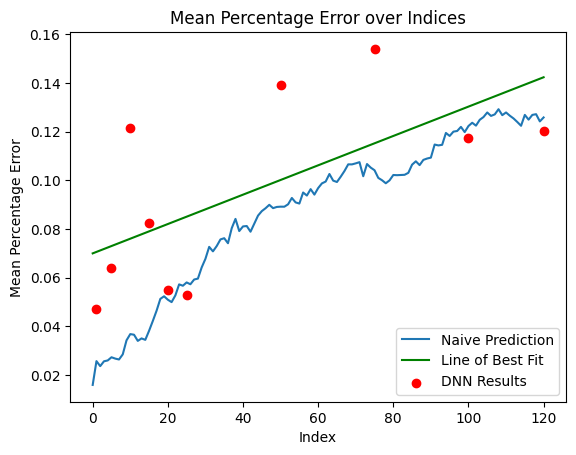

In [ ]:
# MPE for results above
NNMPE = [(1,0.04733707384221354),(5,0.06390415050163106),(10,0.12153474361317829),(15,0.08249563097964752), (20,0.05513346915237138), (25,0.05276450174969322),(50,0.13897488659262722),(75,0.1539913522331133),(100,0.11731573202255512),(120,0.12030392573152014)]
nnmpe_x = [item[0] for item in NNMPE]
nnmpe_y = [item[1] for item in NNMPE]

# Extract the first value (mean percentage error) from each tuple in defaultMPE
mean_percentage_errors = [item[0] for item in defaultMPE]

# Create a list of indices
indices = list(range(len(defaultMPE)))

# get the line of best fit for MPE results
m, b = np.polyfit(nnmpe_x, nnmpe_y, 1)
y_fit = [m * x + b for x in indices]


# Plot the data
fig, ax = plt.subplots()
p1 = ax.plot(indices, mean_percentage_errors, label="Naive Prediction")
p2 = ax.plot(indices, y_fit, c="green", label="Line of Best Fit")
p3 = ax.scatter(nnmpe_x, nnmpe_y,c="red", label="DNN Results")
plt.xlabel("Index")
plt.ylabel("Mean Percentage Error")
plt.title("Mean Percentage Error over Indices")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,labels,loc="lower right")
plt.show()

<h2>Adding Another Layer</h2>
<p>I added another hidden layer as a quick test of model complexity. This did not seem to offer any quick improvement in the fit and so I turned to expanding the input data as the next step.</p>

In [ ]:
# model definition for the simple model with 2 fully connected hidden layer
def build_model2():
  model = keras.Sequential([
      layers.Dense(125,activation = 'relu'),
      layers.Dense(125,activation = 'relu'),
      layers.Dense(125,activation = 'relu'),
      layers.Dense(1)
  ])
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(26.404720783233643), np.float64(43.58129358291626), np.float64(42.64772391319275), np.float64(11.753980159759521), np.float64(17.237245321273804), np.float64(14.821850061416626), np.float64(10.00909972190857), np.float64(48.15128135681152), np.float64(40.613935708999634), np.float64(11.80188274383545), np.float64(14.184891700744629), np.float64(9.651377081871033), np.float64(30.758435606956482), np.float64(29.12267243862152), np.float64(8.784042000770569), np.float64(30.73305118083954), np.float64(7.90364396572113), np.float64(16.963467836380005), np.float64(7.465604186058044), np.float64(30.656607508659363), np.float64(15.481231570243835), np.float64(9.935359001159668), np.float64(16.839159965515137), np.float64(23.08197259902954), np.float64(6.704642415046692), np.float64(17.17695963382721), np.float64(12.026837587356567), np.float64(11.557159304618835), np.float64(10.897143006324768), np.float64(

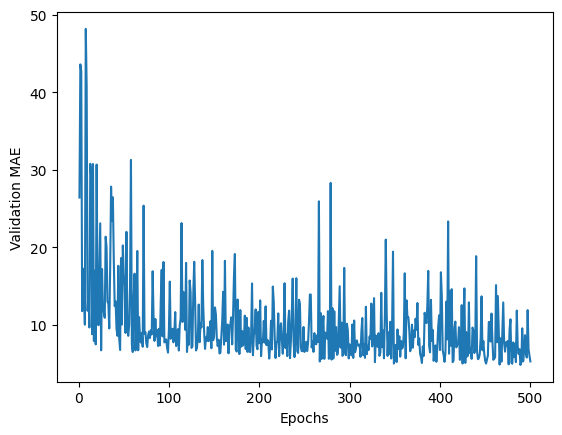

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(46.34521555900574), np.float64(24.828394412994385), np.float64(15.9414381980896), np.float64(33.06843423843384), np.float64(30.95375633239746), np.float64(37.07171392440796), np.float64(11.952094674110413), np.float64(9.668212175369263), np.float64(17.857972383499146), np.float64(47.60184168815613), np.float64(25.153327465057373), np.float64(51.8055362701416), np.float64(23.04591703414917), np.float64(8.935660362243652), np.float64(13.334806442260742), np.float64(23.00617027282715), np.float64(10.449154138565063), np.float64(20.24343514442444), np.float64(9.676145315170288), np.float64(13.184156775474548), np.float64(14.517501831054688), np.float64(30.352724313735962), np.float64(16.04412341117859), np.float64(18.959058046340942), np.float64(10.660035848617554), np.float64(16.771104097366333), np.float64(17.864824295043945), np.float64(14.970387935638428), np.float64(17.003113508224487), np.float64(

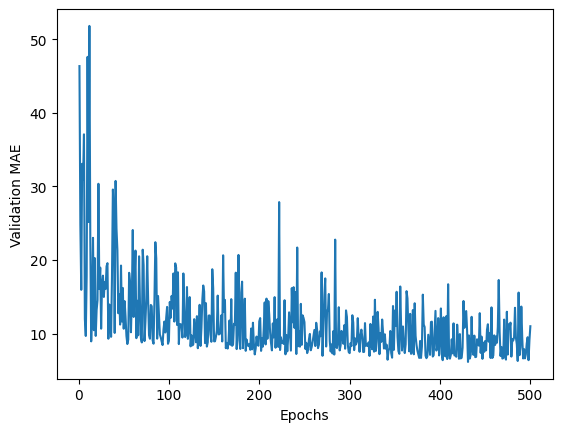

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(29.803759336471558), np.float64(18.17839241027832), np.float64(58.22950077056885), np.float64(11.055694103240967), np.float64(19.511075615882874), np.float64(26.773630380630493), np.float64(8.426449537277222), np.float64(15.405925631523132), np.float64(15.300690174102783), np.float64(15.361445426940918), np.float64(33.13236117362976), np.float64(29.420780539512634), np.float64(27.634904861450195), np.float64(12.724988579750061), np.float64(17.988811492919922), np.float64(11.005710363388062), np.float64(18.077718138694763), np.float64(15.058711290359497), np.float64(9.091904044151306), np.float64(15.1796293258667), np.float64(19.98306894302368), np.float64(16.925684332847595), np.float64(25.02047288417816), np.float64(18.153136372566223), np.float64(11.706149578094482), np.float64(19.328877925872803), np.float64(16.878525018692017), np.float64(9.682509064674377), np.float64(7.834613084793091), np.flo

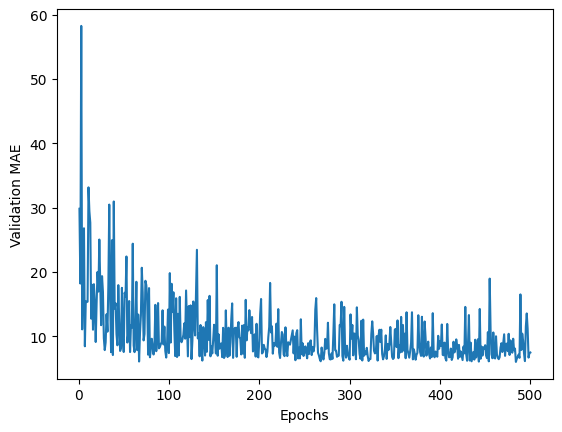

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(12.873440265655518), np.float64(77.0745621919632), np.float64(32.78192925453186), np.float64(78.73252868652344), np.float64(18.66667628288269), np.float64(41.38003349304199), np.float64(28.984721899032593), np.float64(16.875586986541748), np.float64(14.322805166244507), np.float64(24.56166982650757), np.float64(19.55022120475769), np.float64(12.418868780136108), np.float64(24.508204460144043), np.float64(22.856136798858643), np.float64(20.595845460891724), np.float64(17.361242651939392), np.float64(29.286319255828857), np.float64(19.148218154907227), np.float64(13.516321420669556), np.float64(31.183467388153076), np.float64(25.849886178970337), np.float64(20.04977798461914), np.float64(9.739727020263672), np.float64(11.930439710617065), np.float64(15.109773874282837), np.float64(25.342762231826782), np.float64(9.880747556686401), np.float64(12.844691634178162), np.float64(18.94453454017639), np.floa

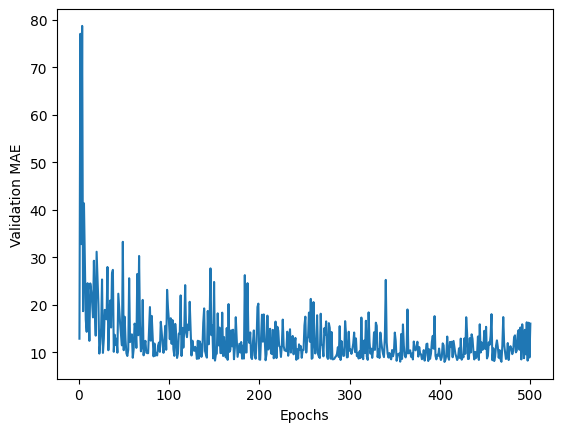

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(20.654359817504883), np.float64(28.742008924484253), np.float64(58.602144718170166), np.float64(17.605008125305176), np.float64(13.50282597541809), np.float64(38.77995467185974), np.float64(26.40061068534851), np.float64(27.131690979003906), np.float64(31.36568307876587), np.float64(18.57494568824768), np.float64(18.50002670288086), np.float64(38.17747092247009), np.float64(9.77846360206604), np.float64(16.500967502593994), np.float64(10.594790935516357), np.float64(26.73110318183899), np.float64(28.900933980941772), np.float64(12.567853212356567), np.float64(10.605893611907959), np.float64(9.129714965820312), np.float64(11.185894012451172), np.float64(27.874738454818726), np.float64(12.3287832736969), np.float64(11.782044410705566), np.float64(30.486974239349365), np.float64(24.682923316955566), np.float64(12.216918468475342), np.float64(13.74052381515503), np.float64(18.99073839187622), np.float64

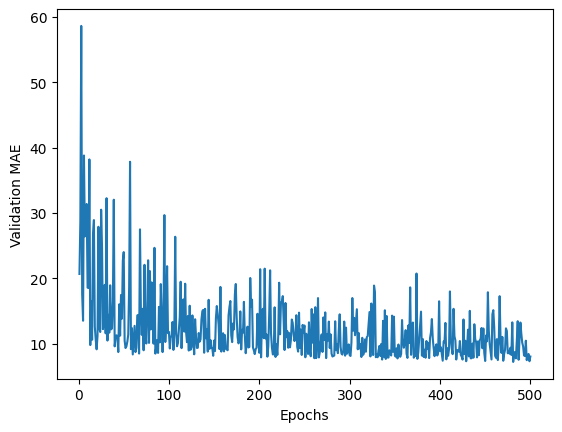

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(23.83166241645813), np.float64(54.49727439880371), np.float64(27.761006355285645), np.float64(18.04749631881714), np.float64(24.11160683631897), np.float64(22.677286386489868), np.float64(28.99004054069519), np.float64(25.35600233078003), np.float64(33.56112480163574), np.float64(14.072314262390137), np.float64(15.437117576599121), np.float64(17.65261435508728), np.float64(11.608664751052856), np.float64(13.259318351745605), np.float64(10.960711479187012), np.float64(33.64628601074219), np.float64(21.962008595466614), np.float64(12.679747343063354), np.float64(12.719551086425781), np.float64(13.109273672103882), np.float64(15.309366941452026), np.float64(15.698543310165405), np.float64(13.790647149085999), np.float64(23.60207176208496), np.float64(18.17204189300537), np.float64(15.529659509658813), np.float64(21.04685139656067), np.float64(12.232805132865906), np.float64(12.277840614318848), np.floa

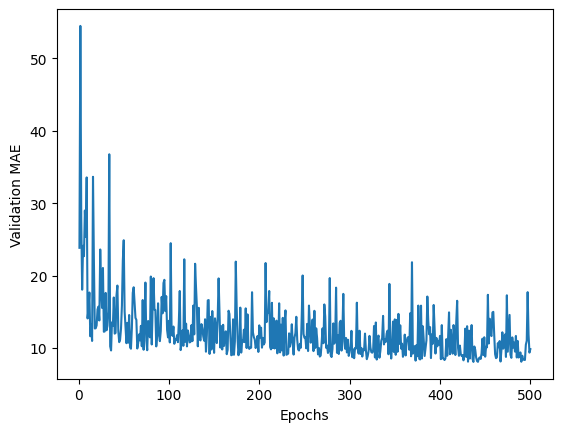

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(42.44683766365051), np.float64(33.518619537353516), np.float64(79.04625034332275), np.float64(28.938076496124268), np.float64(25.393828868865967), np.float64(31.319705963134766), np.float64(41.92737913131714), np.float64(16.217435836791992), np.float64(26.505610466003418), np.float64(19.72256636619568), np.float64(18.480101823806763), np.float64(20.280412435531616), np.float64(13.18628716468811), np.float64(38.26814579963684), np.float64(17.611859798431396), np.float64(16.783750295639038), np.float64(17.42234182357788), np.float64(17.22207021713257), np.float64(11.720389366149902), np.float64(18.922505617141724), np.float64(16.444145917892456), np.float64(23.31480574607849), np.float64(24.30064821243286), np.float64(12.319454431533813), np.float64(25.03858757019043), np.float64(13.801878213882446), np.float64(18.8948175907135), np.float64(21.536540746688843), np.float64(26.23163640499115), np.float6

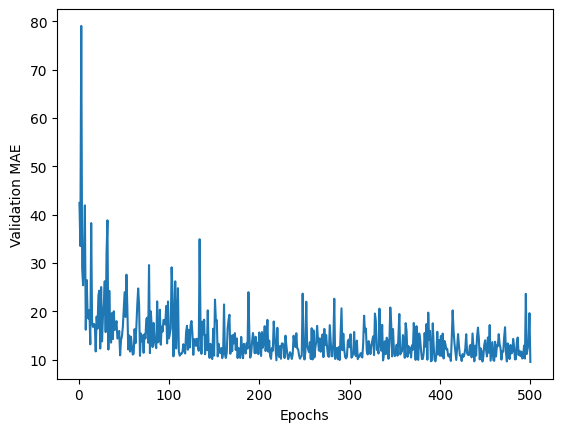

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(33.937849283218384), np.float64(20.287080764770508), np.float64(25.246058225631714), np.float64(19.034820556640625), np.float64(15.529386281967163), np.float64(27.143595695495605), np.float64(19.374227285385132), np.float64(47.4689040184021), np.float64(21.45087456703186), np.float64(16.603245735168457), np.float64(35.52662491798401), np.float64(37.81350135803223), np.float64(18.308894634246826), np.float64(48.580137968063354), np.float64(18.823127508163452), np.float64(22.149672031402588), np.float64(17.18145227432251), np.float64(17.068331956863403), np.float64(24.460537910461426), np.float64(15.87021780014038), np.float64(45.20047116279602), np.float64(18.24401593208313), np.float64(22.424609184265137), np.float64(21.010194301605225), np.float64(17.497016668319702), np.float64(15.588373899459839), np.float64(29.39279866218567), np.float64(20.633268356323242), np.float64(15.190563678741455), np.fl

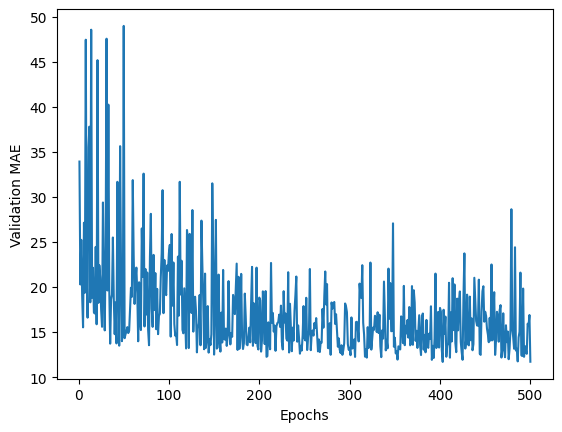

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(44.9339816570282), np.float64(22.954949855804443), np.float64(18.160889148712158), np.float64(28.610275745391846), np.float64(24.06076693534851), np.float64(16.697080373764038), np.float64(20.87849497795105), np.float64(34.94207048416138), np.float64(30.39018416404724), np.float64(17.087395191192627), np.float64(16.40205216407776), np.float64(15.922196865081787), np.float64(29.298686981201172), np.float64(24.756394147872925), np.float64(19.612321138381958), np.float64(22.16244339942932), np.float64(18.852583646774292), np.float64(43.12024641036987), np.float64(20.527541399002075), np.float64(17.190124988555908), np.float64(17.173161268234253), np.float64(15.636204242706299), np.float64(19.935983180999756), np.float64(22.321837663650513), np.float64(25.516379833221436), np.float64(24.24818181991577), np.float64(18.221961498260498), np.float64(23.966610431671143), np.float64(21.7179434299469), np.floa

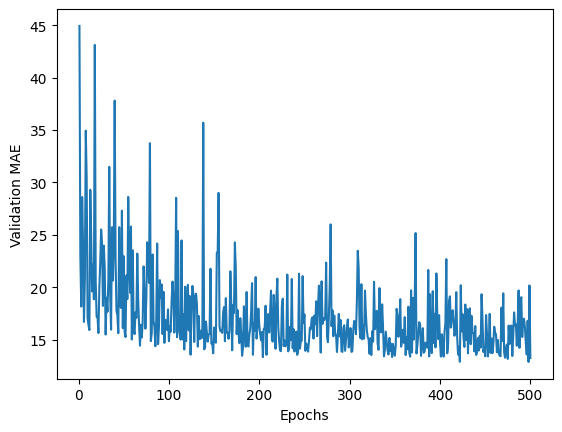

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
[np.float64(68.23663806915283), np.float64(21.231202125549316), np.float64(41.617199420928955), np.float64(27.26410484313965), np.float64(20.528447151184082), np.float64(17.792365550994873), np.float64(19.197827339172363), np.float64(37.63208770751953), np.float64(34.7917275428772), np.float64(29.874072074890137), np.float64(18.52295207977295), np.float64(21.474346160888672), np.float64(50.10450077056885), np.float64(43.105308055877686), np.float64(22.97895860671997), np.float64(24.302571535110474), np.float64(42.9147686958313), np.float64(19.597615003585815), np.float64(19.85532808303833), np.float64(50.08013153076172), np.float64(16.648683309555054), np.float64(21.343149662017822), np.float64(37.94836187362671), np.float64(29.251009941101074), np.float64(36.94371700286865), np.float64(22.691041231155396), np.float64(22.082870721817017), np.float64(15.407328605651855), np.float64(22.08386468887329), np.float64

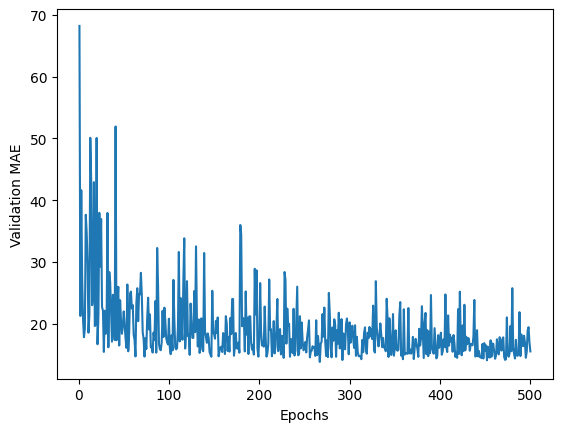

In [ ]:
# this time run the validation curves over a range of timeframes
for i in range(10):
  results = testValidationCurve(build_model2,500,1 + i*5)
  displayValidationCurve(results,500)

<h2>Different Data Normalization</h2>
<p>The above added complexity did not help, so I tried a different normalization strategy, not doing per-column normalization but instead normalizing across the whole dataset, which produced a small increase in accuracy with this network architecture. This normalization improvement, however, did not carry over into the various recurrent neural networks. I believe that for this particular application, the columnwise normalization was inappropriate because that created an inappropriate linkage betweeen the independent motions of different stocks. One stock's rise on a certain day would have an effect on other stocks' values, when really they should be normalized either across the entire set or on a per-stock basis.</p>

In [ ]:
# data normalization, making copies to have the raw stock prices available for
# comparison purposes
unNormedTrainData = train_data.copy()
unNormedTestData = test_data.copy()

mean = train_data.mean()
train_data -= mean
std = train_data.std()
train_data /= std
test_data -= mean
test_data /= std

In [ ]:
print(type(train_data))
print(type(train_targets_all))
print(type(train_data[0][0]))
print(type(train_targets_all[0][0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.float64'>


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1305.9309 - mae: 18.7283
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


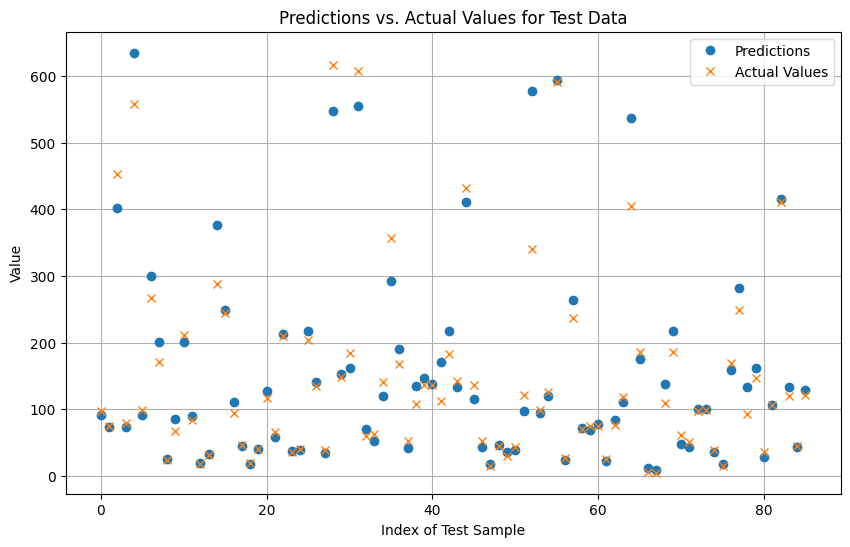

Mean percentage error:  0.13724785606978215
Highest percentage error:  [0.78788026]
Lowest percentage error:  [0.00409008]
Median percentage error:  0.09699396382028784
Standard deviation of percentage error:  0.1492897517155901


np.float64(0.13724785606978215)

In [ ]:
model = build_model1()
train_targets = train_targets_all[:,-100]
test_targets = test_targets_all[:,-100]
model.fit(train_data, train_targets, epochs = 500, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
showModelResults(model.predict(test_data), test_targets)

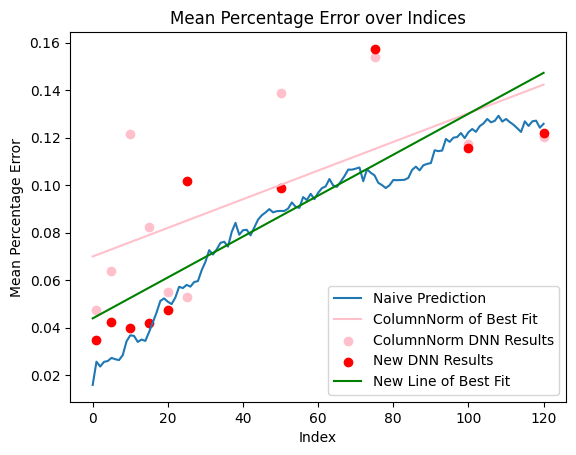

In [ ]:
# MPE for results above
NNMPE = [(1,0.04733707384221354),(5,0.06390415050163106),(10,0.12153474361317829),(15,0.08249563097964752), (20,0.05513346915237138), (25,0.05276450174969322),(50,0.13897488659262722),(75,0.1539913522331133),(100,0.11731573202255512),(120,0.12030392573152014)]
NEW_NNMPE = [(1,0.035015557232996986),(5,0.04242994523885372),(10,0.03994406475869918),(15,0.042016092544414525), (20,0.04747018035821365), (25,0.10157187242973914),(50,0.09869664422448955),(75,0.15735948539220485),(100,0.11566219218348035),(120,0.12191650255683698)]
nnmpe_x = [item[0] for item in NNMPE]
nnmpe_y = [item[1] for item in NNMPE]
new_x = [item[0] for item in NEW_NNMPE]
new_y = [item[1] for item in NEW_NNMPE]

# Extract the first value (mean percentage error) from each tuple in defaultMPE
mean_percentage_errors = [item[0] for item in defaultMPE]

# Create a list of indices
indices = list(range(len(defaultMPE)))

# get the line of best fit for MPE results
m, b = np.polyfit(nnmpe_x, nnmpe_y, 1)
y_fit = [m * x + b for x in indices]

m_new, b_new = np.polyfit(new_x, new_y, 1)
y_fit_new = [m_new * x + b_new for x in indices]

# Plot the data
fig, ax = plt.subplots()
p1 = ax.plot(indices, mean_percentage_errors, label="Naive Prediction")
p2 = ax.plot(indices, y_fit, c="pink", label="ColumnNorm of Best Fit")
p3 = ax.scatter(nnmpe_x, nnmpe_y,c="pink", label="ColumnNorm DNN Results")
p4 = ax.scatter(new_x, new_y,c="red", label="New DNN Results")
p5 = ax.plot(indices,y_fit_new, c="green", label="New Line of Best Fit")

plt.xlabel("Index")
plt.ylabel("Mean Percentage Error")
plt.title("Mean Percentage Error over Indices")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles,labels,loc="lower right")
plt.show()

<h2>Version Issues with Tensorflow</h2>
<p>The code and output below show some of the issues with the Tensorflow and Tensorflowjs dependencies. In particular, the code shown on their tutorials and included in the Chollet textbook all has deprecation warnings and errors. I was eventually able to solve this by manually editing many variable names in a different model I exported, but spent a great deal of time working to no avail to find compatible versions of all the required libraries.</p>

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.8.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.35.1 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_modelExport():
    model = keras.Sequential([
        keras.Input(shape=(125,), name="features"),
        layers.Dense(125, activation='relu'),
        layers.Dense(125, activation='relu'),
        layers.Dense(1, name="target")
    ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

model = build_modelExport()

# Ensure the model is built
_ = model(tf.zeros([1, 125]))
model.fit(train_data, train_targets, epochs = 100, batch_size = 16, verbose = 0)
model.save("model_fixed.keras", save_format="tf")

In [ ]:
!rm -rf web_model
!tensorflowjs_converter --input_format=keras model_fixed.keras web_model

2025-08-24 20:33:56.520118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756067636.544104   19867 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756067636.551121   19867 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756067636.568450   19867 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756067636.568495   19867 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756067636.568499   19867 computation_placer.cc:177] computation placer alr

In [ ]:
import h5py
with h5py.File("model_fixed.h5", "r") as f:
    print("Has keras_version attr? ->", "keras_version" in f.attrs)  # should be True
    print("Attrs:", list(f.attrs.keys()))  # typically includes 'keras_version', 'backend', etc.

Has keras_version attr? -> True
Attrs: ['backend', 'keras_version', 'model_config', 'training_config']


In [ ]:
!rm -rf web_model
!tensorflowjs_converter \
  --input_format=keras \
  --output_format=tfjs_layers_model \
  model_fixed.h5 web_model

2025-08-24 20:24:41.767956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756067081.794688   15965 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756067081.802581   15965 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756067081.822603   15965 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756067081.822675   15965 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756067081.822681   15965 computation_placer.cc:177] computation placer alr

In [ ]:
model.save("test3.keras", include_optimizer=False)  # new format

In [ ]:
import tensorflowjs as tfjs
from tensorflow import keras

# Load the model from the new .keras file
model = keras.models.load_model("test3.keras")

# Export to TF.js format
tfjs.converters.save_keras_model(model, "./mymodel_tfjs")

failed to lookup keras version from the file,
    this is likely a weight only file


<p>Some of the errors I encountered claimed that there were no weights associated with the exported models, and so here I confirmed that was not the case. It eventually turned out that TensorflowJS expected different names for many of these than in the exported versions.</p>

In [ ]:
from tensorflow import keras

model = keras.models.load_model("test3.h5")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,626 (123.54 KB)

 Trainable params: 31,626 (123.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflowjs as tfjs
from tensorflow import keras

# Load the model
model = keras.models.load_model("test3.h5")

# Save in TF.js format
tfjs.converters.save_keras_model(model, "./test3")

failed to lookup keras version from the file,
    this is likely a weight only file
